In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, Input, Bidirectional
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Se cargan los datos numéricos de test para CNN y LSTM
X_test_numeric = np.load('/content/drive/MyDrive/Colab Notebooks/TFM/Networks_X_test.npy')

# Se cargan los textos crudos para el Transformer
df_test_text = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/Transformer_X_test.csv', dtype=str)
X_test_text = df_test_text['review_text'].tolist()

# Se cargan las etiquetas reales
y_test = np.load('/content/drive/MyDrive/Colab Notebooks/TFM/y_test.npy')

In [3]:
# Se define el nombre del modelo pre-entrenado
MODEL_NAME = 'distilbert-base-uncased'

# Se carga el tokenizador
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
MAX_LENGTH = 256

# Se define la función para tokenizar los textos
def tokenize_data(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="tf"
    )

# Se tokenizan los datos de test
test_encodings = tokenize_data(X_test_text)
test_dataset_trans = dict(test_encodings)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [20]:
# Se carga el tokenizador usado en el entrenamiento de CNN/LSTM para saber el tamaño real
with open('/content/drive/MyDrive/Colab Notebooks/TFM/keras_tokenizer.pickle', 'rb') as handle:
    keras_tokenizer = pickle.load(handle)

# Se definen las constantes usando el tokenizador para las redes neuronales
MAX_LENGTH = X_test_numeric.shape[1]
VOCAB_SIZE = len(keras_tokenizer.word_index) + 1
EMBEDDING_DIM = 100


# Se define la arquitectura exacta de la CNN
model_cnn = Sequential([
    Input(shape=(MAX_LENGTH,)),
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_cnn.load_weights('/content/drive/MyDrive/Colab Notebooks/TFM/modelo_cnn_tfm.keras')

# Se define la arquitectura exacta de la LSTM
model_lstm = Sequential([
    Input(shape=(MAX_LENGTH,)),
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_lstm.load_weights('/content/drive/MyDrive/Colab Notebooks/TFM/modelo_lstm_tfm.keras')

# El Transformer se carga aparte porque usa su propia librería
model_trans = TFDistilBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/TFM/modelo_transformer_tfm')

Some layers from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/TFM/modelo_transformer_tfm were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/TFM/modelo_transformer_tfm and are newly initialized: ['dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

In [12]:
# Se cargan los modelos CNN y LSTM entrenados
model_cnn = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/TFM/modelo_cnn_tfm.keras')
model_lstm = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/TFM/modelo_lstm_tfm.keras')

# Se carga el modelo Transformer
model_trans = TFDistilBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/TFM/modelo_transformer_tfm')

Some layers from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/TFM/modelo_transformer_tfm were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/TFM/modelo_transformer_tfm and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

In [13]:
# Se obtienen las predicciones de la CNN
pred_cnn = model_cnn.predict(X_test_numeric)

# Se obtienen las predicciones de la LSTM
pred_lstm = model_lstm.predict(X_test_numeric)

# Se obtienen las predicciones del Transformer
output_trans = model_trans.predict(test_dataset_trans)
pred_logits = output_trans.logits

# Se aplica softmax para obtener probabilidades
pred_trans = tf.nn.softmax(pred_logits, axis=-1).numpy()

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
62/62 [==============================] - 21s 271ms/step


In [18]:
# Se calcula el promedio de las predicciones de los 3 modelos dandole mas valor al transformer
pred_final_probs = (0.25 * pred_cnn) + (0.25 * pred_lstm) + (0.5 * pred_trans)

# Se obtiene la clase con mayor probabilidad
y_pred_ensemble = np.argmax(pred_final_probs, axis=1)

# Se convierten las etiquetas reales a enteros si es necesario
if y_test.ndim > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test + 1


REPORTE FINAL (ENSEMBLE):
                      precision    recall  f1-score   support

Not Recommended (-1)       0.57      0.22      0.32       124
  Mixed Feelings (0)       0.33      0.48      0.39       201
     Recommended (1)       0.93      0.92      0.92      1636

            accuracy                           0.83      1961
           macro avg       0.61      0.54      0.54      1961
        weighted avg       0.84      0.83      0.83      1961



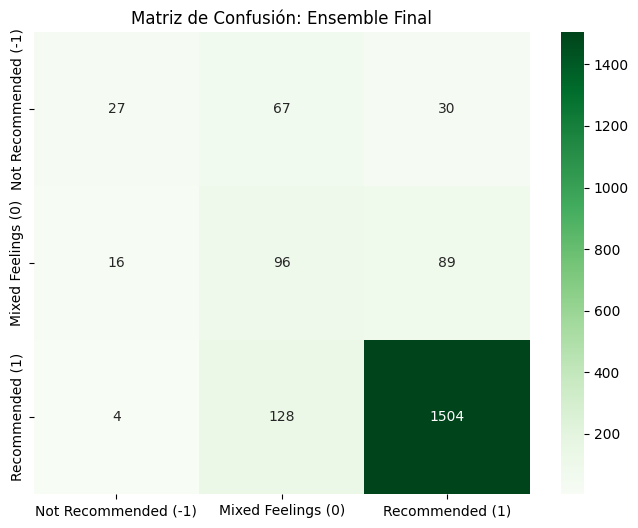

In [19]:
class_names = ['Not Recommended (-1)', 'Mixed Feelings (0)', 'Recommended (1)']

print("\nREPORTE FINAL (ENSEMBLE):")
# Se muestra el reporte de clasificación
print(classification_report(y_true, y_pred_ensemble, target_names=class_names))

# Se genera y muestra la matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión: Ensemble Final')
plt.show()